***Imports***

In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import functions_variables as fv
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

# Disable all warnings
warnings.filterwarnings('ignore')

***Importing Data***

In [2]:
X_train = pd.read_csv('../data/training/X_train_v2.csv')
X_validate = pd.read_csv('../data/training/X_validation.csv')
y_train = pd.read_csv('../data/training/y_train_v2.csv')
y_validate = pd.read_csv('../data/training/y_validatione.csv')

# **Hyperparameter Tuning**

In [3]:
# Add training data together

training_data = pd.concat([X_train, y_train], axis=1)

# Perform custom cross-validation - Function included in Function_variables.py

training_folds, validation_folds = fv.custom_cross_validation(training_data, n_splits=5)

***Hyperparameter Testing Function***

***Decision Tree Hyperparameter Testing***

In [5]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Perform hyperparameter_search - Function included in Function_variables.py

best_params, best_score = fv.hyperparameter_search(training_folds, validation_folds,
                                                param_grid, 'decision_tree')
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 6684026380.854773


***Saving Final Model***

In [6]:
# Train the final model using the best hyperparameters

final_model = DecisionTreeRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Save the final model

joblib.dump(final_model, '../models/test_models/final_decision_tree_model.pkl')

['../models/test_models/final_decision_tree_model.pkl']

***Random Forest Hyperparameter Testing***

In [7]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Perform hyperparameter_search - Function included in Function_variables.py

best_params, best_score = fv.hyperparameter_search(training_folds, validation_folds,
                                                param_grid, 'random_forest')
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 20148153270.871227


***Saving Final Model***

In [8]:
# Train the final model using the best hyperparameters

final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Save the final model

joblib.dump(final_model, '../models/test_models/final_random_forest_model.pkl')

['../models/best-model/final_random_forest_model_v2.pkl']

# **Comparing between Decision Tree and Random Forest**

##### ***Decision Tree Test***

In [9]:
decision_tree_model = joblib.load('../models/test_model/final_decision_tree_model.pkl')

decision_tree_model.fit(X_train, y_train)

y_pred = decision_tree_model.predict(X_validate)

mse = mean_squared_error(y_validate, y_pred)
mae = mean_absolute_error(y_validate, y_pred)
r2 = r2_score(y_validate, y_pred)

print(f"Test Set Performance: MSE = {mse}, MAE = {mae}, R^2 = {r2}")

Test Set Performance: MSE = 6193112904.076359, MAE = 8933.185677371725, R^2 = 0.9863882425065167


##### ***Random Forest Test***


In [10]:
random_forest_model = joblib.load('../models/test_model/final_random_forest_model.pkl')

random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_validate)

mse = mean_squared_error(y_validate, y_pred)
mae = mean_absolute_error(y_validate, y_pred)
r2 = r2_score(y_validate, y_pred)

print(f"Test Set Performance: MSE = {mse}, MAE = {mae}, R^2 = {r2}")

Test Set Performance: MSE = 7214407643.637923, MAE = 24113.28484535849, R^2 = 0.9841435528747272


### **Model Performance Comparison**

#### ***Performance Metrics***

| Metric                 | Decision Tree                       | Random Forest                         |
|------------------------|-----------------------------------------------|----------------------------------------------|
| **Parameters**         | `max_depth`: None, `min_samples_leaf`: 1, `min_samples_split`: 2 | `max_depth`: 20, `min_samples_leaf`: 1, `min_samples_split`: 2, `n_estimators`: 200 |
| **Mean Squared Error** (MSE) | 6,193,112,904.08                         | 7,214,407,643.64                             |
| **Mean Absolute Error** (MAE) | 8,933.19                                 | 24,113.28                                    |
| **R² Score**           | 0.9864                                        | 0.9841                                       |

#### ***Summary***

The table above compares the best tunned decision tree model and random forest model:

- **Parameters Comparisons:**
  - The random forest model has the `n_estimators` parameter
  - They both share the best parameters for the `min_samples_leaf` and `min_samples_splits`
  - Decision tree has the `max depth` of None while random forest has the max depth of 20
  
- **Performance Comparisons:**
  - **MSE** The decision tree has has the lower MSE.
  - **MAE** The decision tree has a significant lower difference in MAE score
  - **R²** The decision tree has a higher r2.

This indicates that overall the decision tree model is the best model compared to the random forest model. The decision tree will be used for the final model.

# **Feature Importance**

The purpose of this section is to inspect the most important features of the chosen model in order to later test to check if we can get an improved model

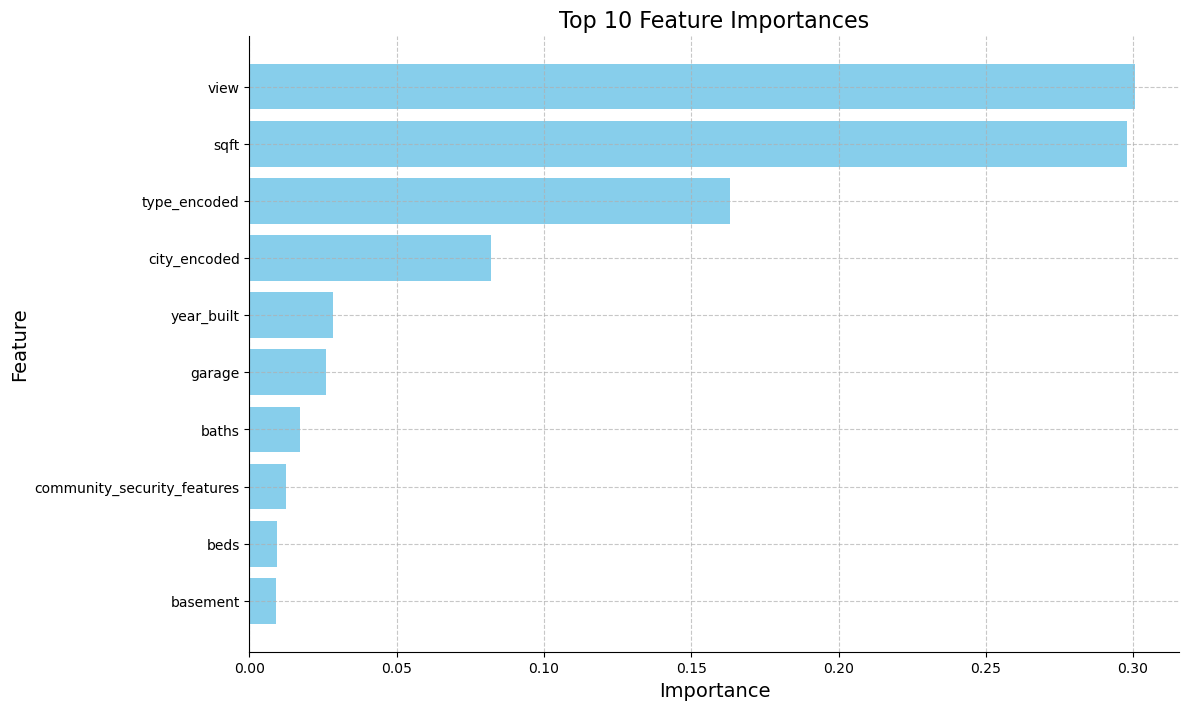

In [11]:
feature_importances = decision_tree_model.feature_importances_
features = X_train.columns


# Create a DataFrame for feature importances

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)


# Plot feature importances

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Feature Importances', fontsize=16)
plt.gca().invert_yaxis()


# Adding grid for better readability

plt.grid(True, linestyle='--', alpha=0.7)


# Removing spines for a cleaner look

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

plt.savefig('../images/top_features_graph.png', format='png')

***Note: The above chart shows `sqft` as one of the most important features. This is in alignment with the heat map generated from part 1 EDA.*** 


![heatmap](../images/correlation_heatmap_new.png)

# **Testing Selected Features**

This portion is to make a model using the top 10 import features shown in the previous section. Using this model we can compare with our previous model to see if feature selection is important for the preformance of our model.

***Feature Selection Model***

In [12]:
# using same model from previous tuning

feature_selection_model = DecisionTreeRegressor(max_depth=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                random_state=42)

# selecting data

X_selected_train = X_train[importance_df['Feature'].tolist()]
X_selected_validate = X_validate[importance_df['Feature'].tolist()]

feature_selection_model.fit(X_selected_train, y_train)

y_pred = feature_selection_model.predict(X_selected_validate)

mse = mean_squared_error(y_validate, y_pred)
mae = mean_absolute_error(y_validate, y_pred)
r2 = r2_score(y_validate, y_pred)

print(f"Test Set Performance: MSE = {mse}, MAE = {mae}, R^2 = {r2}")

Test Set Performance: MSE = 8111175564.110226, MAE = 12319.42906361511, R^2 = 0.9821725590222867


***Saving Model***

In [ ]:
joblib.dump(final_model, '../models/test_models/feature_selection.pkl')

### **Model Performance Comparison**

#### ***Performance Metrics***

| Metric                 | Original Model                       | Feature Selection Model                        |
|------------------------|-----------------------------------------------|----------------------------------------------|
| **Mean Squared Error** (MSE) | 6,193,112,904.08                         | 8,111,175,564.11                             |
| **Mean Absolute Error** (MAE) | 8,933.19                                 | 12,319.43                                    |
| **R² Score**           | 0.9864                                        | 0.9822                                       |

#### ***Summary***

The table above compares the original model with no data changes and a feature selection model with chosen features:
  
- **Performance Comparisons:**
  - **MSE** The original model has a lower MSE score.
  - **MAE** The original model has a significant lower difference in MAE score
  - **R²** The original model has a higher r2.

This indicates that overall the original model is the best model compared to the feature selection model. This means that we do not have to change any of our data and we can use the original model for our final pipeline.

## **Final Pipeline**

This process encapsulates the entire workflow, including data preprocessing, model training, and prediction into a single pipeline. The pipeline is then saved to a file, which can be loaded in the future for making predictions on new data

***Import Data***

In [13]:
X_train = pd.read_csv('../data/training/X_train.csv')
X_test = pd.read_csv('../data/testing/X_test.csv')
y_train = pd.read_csv('../data/training/y_train.csv')
y_test = pd.read_csv('../data/testing/y_test.csv')

**Note:** We decided to use standard scaler and one hot encoding despite not using it during our model selection piece. This addition may cause changes into our model that we recognize

In [14]:
# Define numerical and categorical features
numerical_features = ['year_built', 'sqft', 'baths', 'stories', 'beds', 'garage']
categorical_features = ['type', 'city']

# Create a Feature Union for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [15]:
# Create and fit pipeline

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(max_depth=None,
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year_built', 'sqft',
                                                   'baths', 'stories', 'beds',
                                                   'garage']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type', 'city'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

***Save Pipeline***

In [16]:
pipeline_filename = '../models/final_pipeline/final_pipeline.pkl'
joblib.dump(pipeline, pipeline_filename)
print(f"Pipeline saved to {pipeline_filename}")

Pipeline saved to ../models/pipeline/final_pipeline.pkl


# **Final Test on Model**

This section is to test the data on completely unseen data that was not shown or used during the model selectiong/tuning process. The test will reflect how this model may preform against future data that has not been seen.

In [17]:
pipeline_filename = '../models/final_pipeline/final_pipeline.pkl'
loaded_pipeline = joblib.load(pipeline_filename)

y_pred = loaded_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Performance: MSE = {mse}, MAE = {mae}, R^2 = {r2}")

Test Set Performance: MSE = 3366377871.1668324, MAE = 10258.264462809917, R^2 = 0.989823225121977


### **Model Performance Comparison**

#### ***Performance Metrics***

| Metric                 | Testing Model                       | Final Model                        |
|------------------------|-----------------------------------------------|----------------------------------------------|
| **Mean Squared Error** (MSE) | 6,193,112,904.08                         | 3,366,377,871.16                             |
| **Mean Absolute Error** (MAE) | 8,933.19                                 | 10,258.26                                    |
| **R² Score**           | 0.9864                                        | 0.9898                                       |

#### ***Summary***

The table above compares the original model with no data changes and a feature selection model with chosen features:
  
- **Performance Comparisons:**
  - **MSE** The final model has a significant lower MSE score.
  - **MAE** The testing model has lower MAE score
  - **R²** The final model has a slightly higher r2.

This indicates that our final model that was used on completely new unseen data preforms better than our model we used for selection/tuning. 